# H-SAF H32 Snow Extent



<h3 style="color:blue">Snow Products</h3>

In this session, "H32" product will be used.


## Module 1
-----------------
H32 Snow Extent product is available from the LSA SAF web site (http://landsaf.ipma.pt) which requires registration. 

Near real time data is available via:
- EUMETCast
- Automatic FTP Dissemination (by request)

The file format used is HDF5 and the contents of the files are described in the product documentation (also available from LSA SAF web site. In each file, daily snow extent product is presented in 0.01x0.01 degree lat-lon grid.

For this demo, one example product file (HDF5_LSASAF_M01-AVHR_EDSC_GLOBE_20150211000003) has been retrieved.

## Module 2
-----------------

There are many ways to read the files and use the data. For example, we can use h5py package.

First, import necessary libraries

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors


Then, we can read the data. For snow extent, you do not need scale and offset values, but other attributes can be read in the same way. The attributes are described in the product documentation.

In [2]:
data_filename = './HDF5_LSASAF_M01-AVHR_EDSC_GLOBE_20150211000003'
fid = h5py.File(data_filename,'r')
dataset = fid['SC']
scale = dataset.attrs['SCALING_FACTOR']
offset = dataset.attrs['OFFSET']
sc_data = np.array(dataset)/scale+offset
fid.close()


Let see that the snow extent data has been read into the variable sc_data

In [3]:
sc_data[4580:4590, 18700:18710]


array([[4., 4., 4., 4., 4., 4., 4., 4., 4., 1.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 1.],
       [1., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [1., 1., 1., 4., 1., 1., 4., 4., 4., 4.],
       [1., 1., 1., 1., 1., 4., 4., 4., 4., 4.],
       [1., 1., 1., 1., 4., 4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4., 3., 3., 3., 4., 4.],
       [4., 4., 4., 4., 4., 3., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4., 4., 4., 3., 4., 4.]])

The array contains integers as expected.

Every pixel in the product describes the snow extent using the classifications:<br>
0 Pixel is not processed<br>
1 Full snow cover<br>
2 Partial snow cover<br>
3 No snow<br>
4 Pixel could not be classified (night, clouds, classification uncertain<br>
5 Water

The data can then be used in applications. 

Next step can be plotting the data to see what kind of data we have. First, we create a figure and define a colormap, which helps to understand the image. Then we plot the image. We must define the minimum and maximum values in the array for that to work. 

MemoryError: 

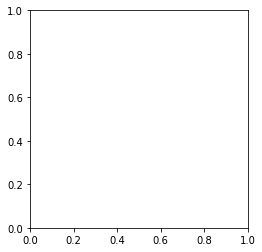

In [4]:
plt.figure()
sc_colormap = colors.ListedColormap(['gray','white','lightgrey',
                                  'forestgreen','black','deepskyblue'])
plt.imshow(sc_data, vmin=0, vmax=6, cmap=sc_colormap)
plt.show()

## Module 3
-----------------


### Pytroll reprojection and plotting example
-----------------



Pytroll can be used to analyse and process the data. We have used NASA Worldview and retrieved a snapshot MODIS image in geoTIFF format (saved as Europe.tiff). We can then use Pytroll functions to reproject H32 Snow Extent to the same projection used in the MODIS geotiff.

First we must import some packages


In [ ]:
import numpy as np
from satpy import Scene
from pyresample import kd_tree, geometry
import h5py
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


Then we need to define some functions. The reprojected_to_tiff reads the geotiff and reprojects the snow extent to the same projection and cuts the same area from the data. We must also create arrays (lats and lons) which contain the pixels coordinates of the H32 product. See the pytroll documentation for details.

In [10]:
def reprojected_to_tiff(ref_fname, snow_fname, resolution=0.10):
    """
    Reproject snow product to geotiff area
    """

    # Read area of the reference image
    scn = Scene(reader='generic_image', filenames=[ref_fname])
    scn.load(['image'])
    target_area = scn['image'].area
    
    # Read data and coordinates
    # Read snow data and coordinates
    with h5py.File(snow_fname,'r') as fid:
        data = fid['SC'][()]
        lon_vect = np.arange(-180.00, 179.99, resolution)
        lat_vect = np.arange(89.99, -89.99, -resolution)
        lons,lats = np.meshgrid(lon_vect, lat_vect)

    # Create swath definition for the input data
    swath_def = geometry.SwathDefinition(lons=lons, lats=lats)
    
    # Resample using nearest-neighbour interpolation
    result = kd_tree.resample_nearest(swath_def, data, target_area, 
                                      radius_of_influence=1000)

    return scn['image'], result

Then we define plot_2, which contains the actual code for drawing the MODIS image and reprojected snow product. The code <br>
1. creates a colormap<br>
2. transposes and scales the tiff image<br>
3. plots the MODIS image<br>
4. plots the snow map with legend

If you want to save the image you can use one of the commented (marked by #) plt.savefig lines at the end. If this code is used in python shell or in a package, the line plt.ion() turns on the interactive mode.


In [11]:
def plot_2(tiff_image, snow1, title0='', title1='', figname='tmp', single='no'):
    """
    Plot MODIS vs H31/H32.
    """
    sc_colormap = colors.ListedColormap(['gray','white','lightgrey',
                                  'forestgreen','black','deepskyblue'])
    # Transpose and scale tiff
    modis = np.zeros((snow1.shape[0], snow1.shape[1], 3), dtype=float)
    modis[:,:,0] = tiff_image[0]/255
    modis[:,:,1] = tiff_image[1]/255
    modis[:,:,2] = tiff_image[2]/255

    plt.figure(1,figsize=(8,10))
    plt.clf()
    #plt.ion()

    plt.subplot(211)
    plt.title(title0)
    plt.axis('off')
    plt.imshow(modis)#

    plt.subplot(212)
    plt.title(title1)
    plt.axis('off')
    plt.imshow(snow1, vmin=0, vmax=6, cmap=sc_colormap)
    plt.legend([mpatches.Patch(facecolor='white',edgecolor='black'), 
                mpatches.Patch(facecolor='lightgrey',edgecolor='black'), 
                mpatches.Patch(facecolor='forestgreen',edgecolor='black'), 
                mpatches.Patch(facecolor='deepskyblue',edgecolor='black'), 
                mpatches.Patch(facecolor='black',edgecolor='black')], 
               ['snow', 'partial', 'no snow', 'water','not classified'], loc=3)#

    plt.tight_layout()
    plt.show()
    #plt.savefig(figname+".pdf", papertype = 'a4', orientation = 'portrait', format = 'pdf')
    #plt.savefig(figname+".png", papertype = 'a4', orientation = 'portrait', format = 'png')


All this is used in plot_areaH32 which calls reprojected_to_tiff with suitable parameters and then the plotting function with the data returned from the reprojection.

In [12]:
def plot_areaH32(tiff_name='some.tiff', snow_name='H32_filename', day='', figname='', single='no'):
    """
    Plot the area in the geotiff, 1x2 (MODIS, H32).
    """
    t_image, snow1 = reprojected_to_tiff(tiff_name,snow_name,resolution=0.01)
    plot_2(t_image, snow1,
           title0='MODIS '+day,
           title1='H32 '+day,
           figname=figname+'H32')

Now we can run the code which needs little bit of time to draw a pretty image you can use to compare MODIS RGB image and H32 Snow Extent product.

In [15]:
plot_areaH32(tiff_name='Europe.tiff', snow_name='./HDF5_LSASAF_M01-AVHR_EDSC_GLOBE_20150211000003', 
             day='20150211', figname='at')

MemoryError: 


### NWP data assimilation example
-----------------

Snow extent products can be used in weather model data assimilation. It will not be the only or even primary data source for snow cover, but satellite snow extent product can improve snow analysis especially in areas where weather stations do not measure snow cover.

The picture below presents one way to use satellite snow extent data in weather model data assimilation in three step. In step 1, high resolution satellite data is converted to suitable resolution for the weather model. In step 2 these observations are converted to pseudo-observations which can be assimilated in the normal data assimilation process in step 3.

![title](./NWP_example.png)

